# Neuropathology Visium Analysis
## Analysis of Cerebellar Layer Measurements Sorted by Gestational Age

This notebook analyzes measurements from different cerebellar layers (ML, IGL, EGL, WM) 
and creates heatmaps sorted by gestational age (GA).

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set output directory
output_dir = Path('/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium/output')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {output_dir}")

# Create a function to save figures
def save_figure(fig_name, fig=None, dpi=300):
    """Save the current figure as PDF in the output directory"""
    if fig is None:
        fig = plt.gcf()
    output_path = output_dir / f"{fig_name}.pdf"
    plt.savefig(output_path, format='pdf', dpi=dpi, bbox_inches='tight')
    print(f"Saved: {output_path.name}")

Output directory set to: /Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium/output


## 2. Load and Initial Data Exploration

In [2]:
# Define file path - update this to your actual file location
csv_file_path = '/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium/measurements.csv'

# Load the data
print("Loading data from CSV file...")
df = pd.read_csv(csv_file_path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading data from CSV file...

Dataset shape: (75, 11)
Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Area µm^2', 'Perimeter µm']

First few rows:


,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Perimeter µm
0,1055A.tif - BF.ome.tif,3406140d-289a-4183-9c60-4b2bb3c46a4c,Annotation,4.0,WM,Root object (Image),Geometry,5575.6,5120.3,1009275.1,19417.1
1,1055A.tif - BF.ome.tif,7a6de77b-e1b3-49e9-aefd-00501e43ab69,Annotation,1.0,EGL,Root object (Image),Geometry,5002.9,5067.5,752911.5,63362.4
2,1055A.tif - BF.ome.tif,db96d5d0-a937-44fd-ad6c-12612a1cde6d,Annotation,3.0,ML,Root object (Image),Geometry,4726.3,4520.2,7956042.7,97074.1
3,1055A.tif - BF.ome.tif,ea3a6a5b-c59d-4b72-b6b8-4ac708b48167,Annotation,2.0,IGL,Root object (Image),Geometry,5044.4,4038.4,10152471.3,75625.2
4,1055A.tif - BF.ome.tif,d45c7934-8bf0-427a-b1b3-e5c21ba4b26f,Annotation,3.0,ML_IGL_150uM,Root object (Image),Geometry,5077.3,4261.5,4460116.7,62817.0


## 3. Data Preprocessing
### 3.1 Extract Sample ID and Image Letter from Image Column

In [3]:
# Extract sample information from the Image column
print("Extracting sample ID and image letter from Image column...")

# Step 1: Keep only the part before the first period
# Example: '1055A.tif-BF.ome.tif' -> '1055A'
df['temp'] = df['Image'].str.split('.', n=1).str[0]

# Step 2: Split into numeric (ID) and letter (Image) parts
# Example: '1055A' -> ID='1055', Image='A'
df['ID'] = df['temp'].str.extract('(\d+)', expand=False)  # Extract numbers
df['Image_Letter'] = df['temp'].str.extract('([A-Za-z]+)', expand=False)  # Extract letters

# Create Sample column by combining ID and Image_Letter
df['Sample'] = df['ID'] + df['Image_Letter']

# Drop the temporary column
df = df.drop('temp', axis=1)

# Display the results
print("\nSample ID and Image extraction complete:")
print(df[['Image', 'ID', 'Image_Letter', 'Sample']].head())

Extracting sample ID and image letter from Image column...

Sample ID and Image extraction complete:
                    Image    ID Image_Letter Sample
0  1055A.tif - BF.ome.tif  1055            A  1055A
1  1055A.tif - BF.ome.tif  1055            A  1055A
2  1055A.tif - BF.ome.tif  1055            A  1055A
3  1055A.tif - BF.ome.tif  1055            A  1055A
4  1055A.tif - BF.ome.tif  1055            A  1055A


### 3.2 Add Gestational Age (GA) Information

In [4]:
# Define GA mapping based on provided information
ga_mapping = {
    '1055': 38,
    '1061': 40,
    '1210': 39,
    '4276': 26,
    '4389': 34,
    '4544': 30,
    '934': 27
}

# Exclude ID 1208 as specified
print(f"\nNumber of rows before excluding ID 1208: {len(df)}")
df = df[df['ID'] != '1208']
print(f"Number of rows after excluding ID 1208: {len(df)}")

# Add GA_weeks column
df['GA_weeks'] = df['ID'].map(ga_mapping)

# Verify the mapping
print("\nGA mapping verification:")
ga_summary = df[['ID', 'GA_weeks']].drop_duplicates().sort_values('GA_weeks')
print(ga_summary)

# Check for any missing GA values
missing_ga = df[df['GA_weeks'].isnull()]['ID'].unique()
if len(missing_ga) > 0:
    print(f"\nWarning: The following IDs have no GA mapping: {missing_ga}")


Number of rows before excluding ID 1208: 75
Number of rows after excluding ID 1208: 65

GA mapping verification:
      ID  GA_weeks
35  4276        26
65   934        27
55  4544        30
45  4389        34
0   1055        38
25  1210        39
10  1061        40


### 3.3 Clean Column Names and Check Classifications

In [5]:
# Rename columns to remove units for easier handling
df = df.rename(columns={
    'Area µm^2': 'Area',
    'Perimeter µm': 'Perimeter',
    'Centroid X µm': 'Centroid_X',
    'Centroid Y µm': 'Centroid_Y'
})

print("Column names cleaned.")

# Check unique classifications
print("\nUnique classifications in the dataset:")
print(df['Classification'].unique())

# Note: We keep ML_IGL_150uM in the dataset for normalization purposes
# It will be used for perimeter calculation but excluded from visualizations
if 'ML_IGL_150uM' in df['Classification'].unique():
    print("\nML_IGL_150uM found - keeping it for perimeter normalization")
    ml_igl_count = len(df[df['Classification'] == 'ML_IGL_150uM'])
    print(f"Number of ML_IGL_150uM measurements: {ml_igl_count}")

Column names cleaned.

Unique classifications in the dataset:
['WM' 'EGL' 'ML' 'IGL' 'ML_IGL_150uM']

ML_IGL_150uM found - keeping it for perimeter normalization
Number of ML_IGL_150uM measurements: 13


## 4. Calculate Normalized Areas

### Normalization: Total Area / (Layer Perimeter / 2)
As per the methodology: area(μm²) / (perimeter(µm)/2) = normalized area

In [6]:
def calculate_normalized_areas(df):
    """
    Calculate normalized areas for all layers using ML_IGL_150uM perimeter as reference.
    
    For each sample:
    - Use ML_IGL_150uM perimeter / 2 as the normalization factor
    - Calculate area / (ML_IGL_150uM perimeter / 2) for each layer
    - ML_IGL_150uM is used ONLY for perimeter, not included in area calculations
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The data containing area and perimeter measurements
    
    Returns:
    --------
    dict
        Dictionary with layer names as keys and normalized areas as values
    """
    # First, get ML_IGL_150uM perimeter for each sample (this will be our reference)
    ml_igl_data = df[df['Classification'] == 'ML_IGL_150uM']
    
    if len(ml_igl_data) == 0:
        print("Error: No ML_IGL_150uM data found. Cannot normalize without ML_IGL_150uM perimeter.")
        return {}
    
    # Get ML_IGL_150uM perimeter for each sample
    ml_igl_perimeters = ml_igl_data.groupby('Sample')['Perimeter'].first()
    
    # Calculate length (perimeter / 2)
    ml_igl_lengths = ml_igl_perimeters / 2
    
    print(f"Found ML_IGL_150uM perimeter data for {len(ml_igl_lengths)} samples")
    
    # Initialize results dictionary
    normalized_data = {}
    
    # For each layer (excluding ML_IGL_150uM), calculate its area normalized by ML_IGL_150uM length
    layers = ['ML', 'IGL', 'EGL', 'WM']  # Note: ML_IGL_150uM is NOT included here
    
    for layer in layers:
        # Get area data for this layer
        layer_data = df[df['Classification'] == layer]
        
        if len(layer_data) == 0:
            print(f"Warning: No data found for {layer} classification")
            normalized_data[layer] = pd.Series()
            continue
        
        # Get area for each sample (using first occurrence if multiple)
        layer_areas = layer_data.groupby('Sample')['Area'].first()
        
        # Find samples that have both ML_IGL_150uM perimeter and layer area
        common_samples = ml_igl_lengths.index.intersection(layer_areas.index)
        
        if len(common_samples) == 0:
            print(f"Warning: No common samples between ML_IGL_150uM and {layer}")
            normalized_data[layer] = pd.Series()
            continue
        
        # Calculate normalized area: Layer Area / ML_IGL_150uM Length
        normalized_areas = layer_areas[common_samples] / ml_igl_lengths[common_samples]
        
        normalized_data[layer] = normalized_areas
        
        print(f"{layer}: Found {len(common_samples)} samples with both area and ML_IGL_150uM perimeter")
    
    return normalized_data

# Calculate normalized areas for all layers
print("Calculating normalized areas using ML_IGL_150uM perimeter as reference...")
normalized_data = calculate_normalized_areas(df)

# Display statistics for each layer
layers = ['ML', 'IGL', 'EGL', 'WM']
for layer in layers:
    if layer in normalized_data and len(normalized_data[layer]) > 0:
        print(f"\n{layer} - Number of samples: {len(normalized_data[layer])}")
        print(f"Mean normalized area: {normalized_data[layer].mean():.2f}")
        print(f"Std deviation: {normalized_data[layer].std():.2f}")
        print(f"Range: {normalized_data[layer].min():.2f} - {normalized_data[layer].max():.2f}")

Calculating normalized areas using ML_IGL_150uM perimeter as reference...
Found ML_IGL_150uM perimeter data for 13 samples
ML: Found 13 samples with both area and ML_IGL_150uM perimeter
IGL: Found 13 samples with both area and ML_IGL_150uM perimeter
EGL: Found 13 samples with both area and ML_IGL_150uM perimeter
WM: Found 13 samples with both area and ML_IGL_150uM perimeter

ML - Number of samples: 13
Mean normalized area: 171.65
Std deviation: 40.76
Range: 122.72 - 253.31

IGL - Number of samples: 13
Mean normalized area: 270.49
Std deviation: 110.50
Range: 129.09 - 451.70

EGL - Number of samples: 13
Mean normalized area: 28.33
Std deviation: 13.46
Range: 13.89 - 57.41

WM - Number of samples: 13
Mean normalized area: 69.61
Std deviation: 61.14
Range: 17.61 - 198.21


## 5. Create Combined DataFrame with GA Information

In [7]:
# First, let's create a version of the normalized data averaged by ID
averaged_normalized_data = {}

for layer in layers:
    if layer in normalized_data and len(normalized_data[layer]) > 0:
        # Convert to DataFrame for easier manipulation
        layer_df = normalized_data[layer].to_frame(name='Value').reset_index()
        layer_df.columns = ['Sample', 'Value']
        
        # Extract ID from Sample (e.g., '1055A' -> '1055')
        layer_df['ID'] = layer_df['Sample'].str.extract('(\d+)', expand=False)
        
        # Group by ID and take the mean
        averaged_values = layer_df.groupby('ID')['Value'].mean()
        
        averaged_normalized_data[layer] = averaged_values
        
        # Print statistics about averaging
        print(f"\n{layer} Layer:")
        sample_counts = layer_df.groupby('ID').size()
        for id_val, count in sample_counts.items():
            if count > 1:
                samples = layer_df[layer_df['ID'] == id_val]['Sample'].tolist()
                values = layer_df[layer_df['ID'] == id_val]['Value'].tolist()
                mean_val = averaged_values[id_val]
                print(f"  ID {id_val}: Averaged {count} images {samples} → Mean: {mean_val:.2f}")

# Create combined dataframe with averaged values
combined_df = pd.DataFrame()

# Add averaged normalized values for each layer
for layer in layers:
    if layer in averaged_normalized_data and len(averaged_normalized_data[layer]) > 0:
        # Convert series to dataframe and reset index
        temp_df = averaged_normalized_data[layer].to_frame(name=f'{layer}_Normalized').reset_index()
        temp_df.columns = ['ID', f'{layer}_Normalized']
        
        # Add GA information
        id_to_ga = df[['ID', 'GA_weeks']].drop_duplicates().set_index('ID')['GA_weeks']
        temp_df['GA_weeks'] = temp_df['ID'].map(id_to_ga)
        
        if combined_df.empty:
            combined_df = temp_df
        else:
            # Merge only the normalized column for subsequent layers
            combined_df = combined_df.merge(temp_df[['ID', f'{layer}_Normalized']], 
                                            on='ID', how='outer')

# Sort by GA weeks
combined_df = combined_df.sort_values('GA_weeks')

print("\nCombined dataframe with averaged normalized values (by ID):")
print(combined_df)


ML Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 253.22
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 177.76
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 129.67
  ID 4389: Averaged 2 images ['4389A', '4389B'] → Mean: 164.11
  ID 4544: Averaged 2 images ['4544A', '4544B'] → Mean: 141.59
  ID 934: Averaged 2 images ['934A', '934B'] → Mean: 157.36

IGL Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 344.41
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 182.70
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 310.92
  ID 4389: Averaged 2 images ['4389A', '4389B'] → Mean: 183.72
  ID 4544: Averaged 2 images ['4544A', '4544B'] → Mean: 132.05
  ID 934: Averaged 2 images ['934A', '934B'] → Mean: 441.78

EGL Layer:
  ID 1055: Averaged 2 images ['1055A', '1055B'] → Mean: 34.28
  ID 1210: Averaged 2 images ['1210A', '1210B'] → Mean: 17.37
  ID 4276: Averaged 2 images ['4276A', '4276B'] → Mean: 27.01
  ID 4389: Averaged 2 images 

## 6. Create Individual Heatmaps for Each Layer (Sorted by GA)

Saved: ML_layer_heatmap.pdf


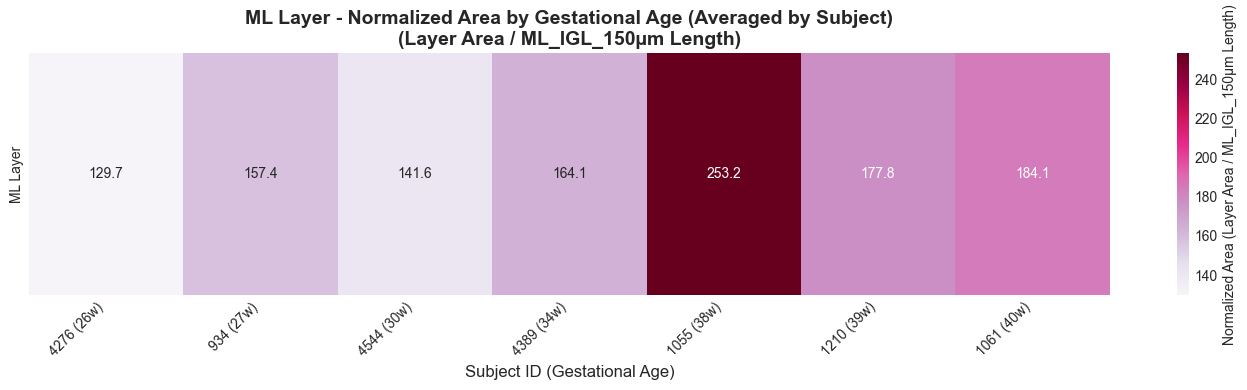


ML Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 172.54
Std: 40.35
Range: 129.67 - 253.22
Saved: IGL_layer_heatmap.pdf


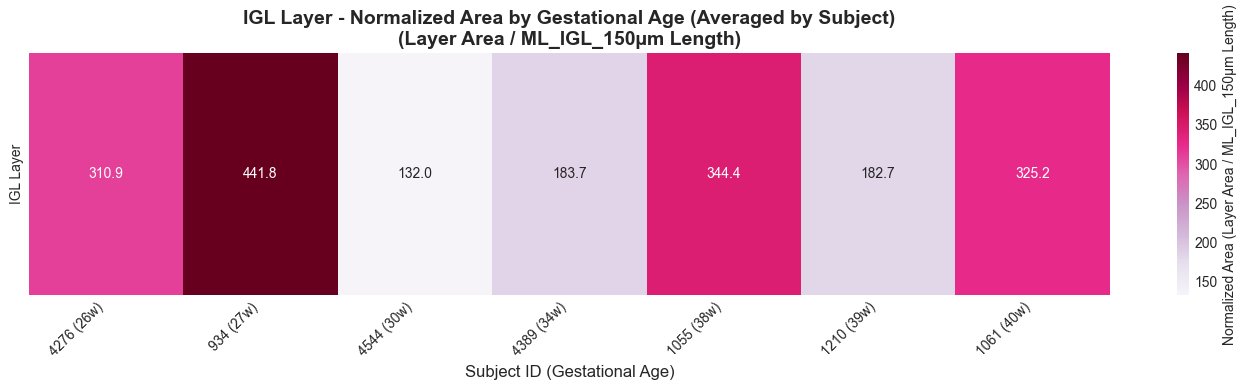


IGL Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 274.40
Std: 110.86
Range: 132.05 - 441.78
Saved: EGL_layer_heatmap.pdf


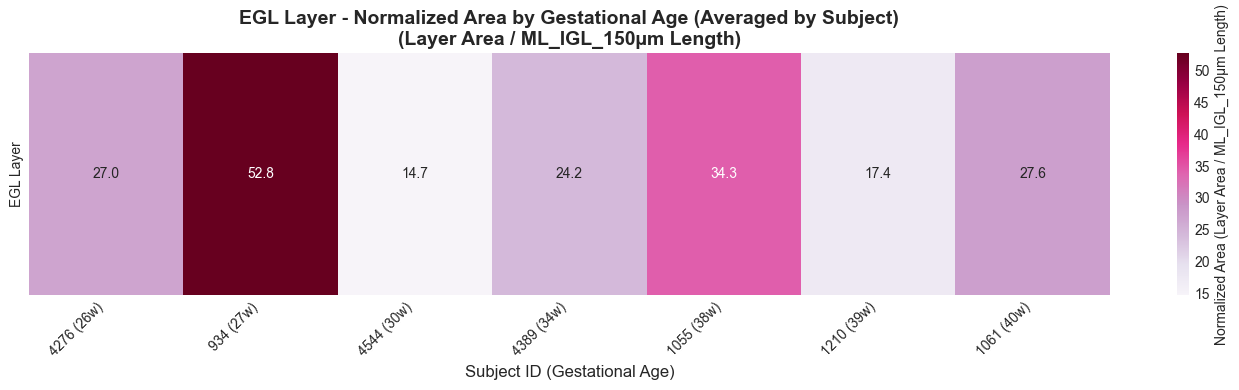


EGL Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 28.28
Std: 12.64
Range: 14.68 - 52.77
Saved: WM_layer_heatmap.pdf


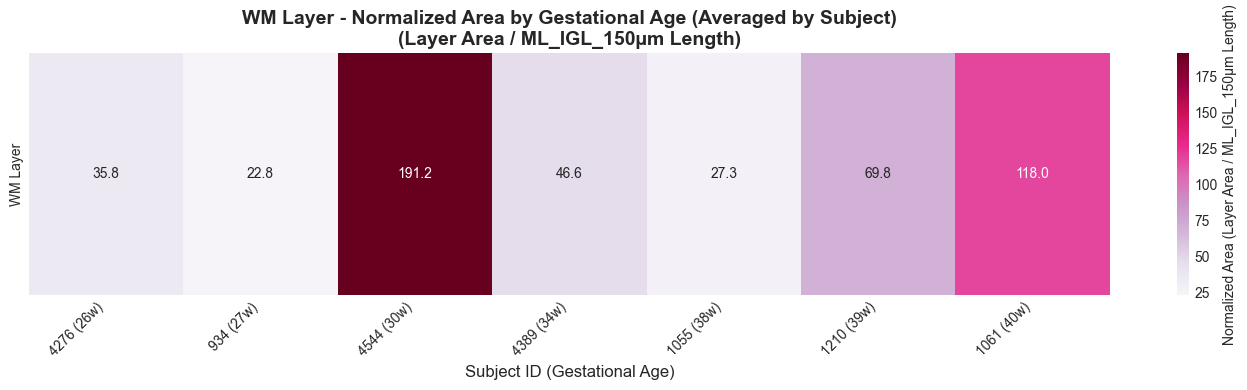


WM Layer Statistics (Averaged by Subject):
Subjects: 7
Mean: 73.07
Std: 61.50
Range: 22.80 - 191.21


In [13]:
# Define color schemes for each layer
color_schemes = {
    'ML': 'PuRd',     # Yellow to Orange to Red - YlOrRd
    'IGL': 'PuRd',      # Purple to Red - PuRd
    'EGL': 'PuRd',    # Yellow to Green to Blue - YlGnBu
    'WM': 'PuRd'        # Blue to Green - BuGn
}

# Create individual heatmaps for each layer
for layer in layers:
    if f'{layer}_Normalized' not in combined_df.columns:
        print(f"\nSkipping {layer} - no data available")
        continue
    
    # Prepare data for heatmap - using ID instead of Sample
    heatmap_data = combined_df[['ID', 'GA_weeks', f'{layer}_Normalized']].dropna()
    
    if len(heatmap_data) == 0:
        print(f"\nNo data available for {layer} layer")
        continue
    
    # Create ID labels with GA information
    heatmap_data['ID_GA'] = heatmap_data['ID'] + ' (' + heatmap_data['GA_weeks'].astype(str) + 'w)'
    
    # Pivot for heatmap format
    heatmap_matrix = heatmap_data.set_index('ID_GA')[[f'{layer}_Normalized']].T
    
    # Create figure
    plt.figure(figsize=(14, 4))
    
    # Create heatmap
    sns.heatmap(heatmap_matrix,
                cmap=color_schemes[layer],
                annot=True,
                fmt='.1f',
                cbar_kws={'label': f'Normalized Area (Layer Area / ML_IGL_150µm Length)'},
                xticklabels=True,
                yticklabels=[f'{layer} Layer'])
    
    # Customize plot
    plt.title(f'{layer} Layer - Normalized Area by Gestational Age (Averaged by Subject)\n(Layer Area / ML_IGL_150µm Length)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    save_figure(f'{layer}_layer_heatmap')
    
    # Show plot
    plt.show()
    
    # Print statistics
    print(f"\n{layer} Layer Statistics (Averaged by Subject):")
    print(f"Subjects: {len(heatmap_data)}")
    print(f"Mean: {heatmap_data[f'{layer}_Normalized'].mean():.2f}")
    print(f"Std: {heatmap_data[f'{layer}_Normalized'].std():.2f}")
    print(f"Range: {heatmap_data[f'{layer}_Normalized'].min():.2f} - {heatmap_data[f'{layer}_Normalized'].max():.2f}")


## 7. Create Combined Heatmap (All Layers)

Saved: combined_heatmap_actual_values.pdf


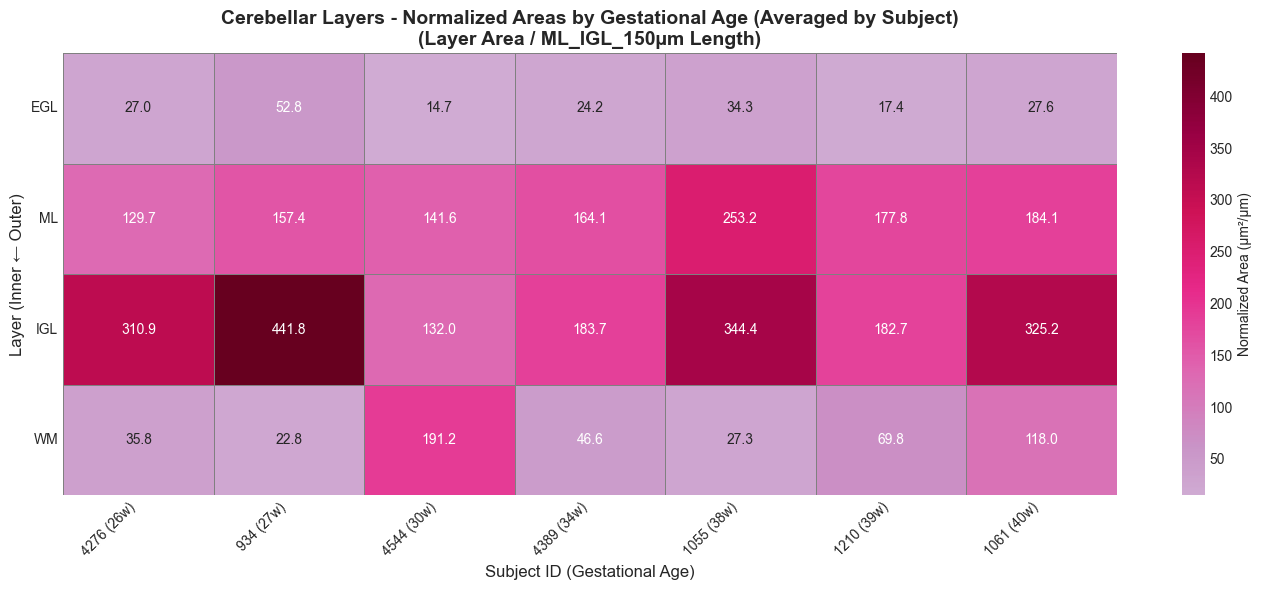

Saved: combined_heatmap_row_normalized.pdf


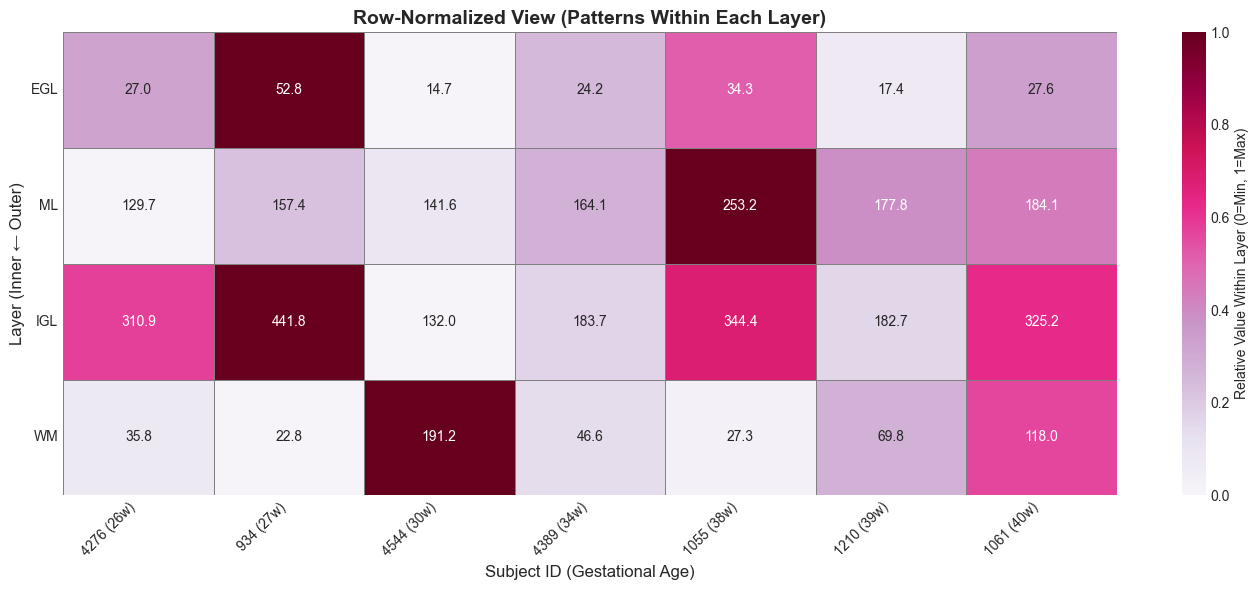


Layer Statistics (from outer to inner, averaged by subject):

EGL (External Granular Layer (Outermost))
  Mean: 28.28 µm²/µm
  Range: 14.68 - 52.77 µm²/µm
  CV: 44.7%

ML (Molecular Layer)
  Mean: 172.54 µm²/µm
  Range: 129.67 - 253.22 µm²/µm
  CV: 23.4%

IGL (Internal Granular Layer)
  Mean: 274.40 µm²/µm
  Range: 132.05 - 441.78 µm²/µm
  CV: 40.4%

WM (White Matter (Innermost))
  Mean: 73.07 µm²/µm
  Range: 22.80 - 191.21 µm²/µm
  CV: 84.2%


In [15]:
# Prepare data for combined heatmap with anatomical ordering
heatmap_combined = pd.DataFrame()

# Define anatomical order from outer to inner
anatomical_order = ['EGL', 'ML', 'IGL', 'WM']

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        layer_data = combined_df[['ID', 'GA_weeks', col_name]].dropna()
        layer_data['Layer'] = layer
        layer_data['Value'] = layer_data[col_name]
        layer_data['ID_GA'] = layer_data['ID'] + ' (' + layer_data['GA_weeks'].astype(str) + 'w)'
        heatmap_combined = pd.concat([heatmap_combined, layer_data[['ID_GA', 'Layer', 'Value', 'GA_weeks']]])

# Pivot for heatmap
if not heatmap_combined.empty:
    # Sort by GA weeks
    id_order = heatmap_combined.sort_values('GA_weeks')['ID_GA'].unique()
    
    heatmap_pivot = heatmap_combined.pivot(index='Layer', columns='ID_GA', values='Value')
    
    # Reorder rows by anatomical sequence and columns by GA
    available_layers = [layer for layer in anatomical_order if layer in heatmap_pivot.index]
    heatmap_pivot = heatmap_pivot.loc[available_layers, id_order]
    
    # Normalize each layer separately for better visualization
    heatmap_normalized = heatmap_pivot.copy()
    for layer in heatmap_normalized.index:
        row_values = heatmap_normalized.loc[layer]
        row_min = row_values.min()
        row_max = row_values.max()
        if row_max > row_min:
            heatmap_normalized.loc[layer] = (row_values - row_min) / (row_max - row_min)
    
    # First plot: Actual values
    plt.figure(figsize=(14, 6))
    
    sns.heatmap(heatmap_pivot,
                cmap='PuRd',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': 'Normalized Area (µm²/µm)'},
                linewidths=0.5,
                linecolor='gray',
                center=heatmap_pivot.mean().mean())
    
    plt.title('Cerebellar Layers - Normalized Areas by Gestational Age (Averaged by Subject)\n(Layer Area / ML_IGL_150µm Length)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('Layer (Inner ← Outer)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Keep simple layer labels
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    # Save figure
    save_figure('combined_heatmap_actual_values')
    
    plt.show()
    
    # Second plot: Row-normalized view
    plt.figure(figsize=(14, 6))
    
    sns.heatmap(heatmap_normalized,
                cmap='PuRd',
                annot=heatmap_pivot.values,  # Show original values
                fmt='.1f',
                cbar_kws={'label': 'Relative Value Within Layer (0=Min, 1=Max)'},
                linewidths=0.5,
                linecolor='gray')
    
    plt.title('Row-Normalized View (Patterns Within Each Layer)', fontsize=14, fontweight='bold')
    plt.xlabel('Subject ID (Gestational Age)', fontsize=12)
    plt.ylabel('Layer (Inner ← Outer)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Keep simple layer labels
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    # Save figure
    save_figure('combined_heatmap_row_normalized')
    
    plt.show()
    
    # Print layer statistics for context
    print("\nLayer Statistics (from outer to inner, averaged by subject):")
    layer_descriptions = {
        'EGL': 'External Granular Layer (Outermost)',
        'ML': 'Molecular Layer',
        'IGL': 'Internal Granular Layer',
        'WM': 'White Matter (Innermost)'
    }
    for layer in available_layers:
        values = heatmap_pivot.loc[layer]
        print(f"\n{layer} ({layer_descriptions.get(layer, '')})")
        print(f"  Mean: {values.mean():.2f} µm²/µm")
        print(f"  Range: {values.min():.2f} - {values.max():.2f} µm²/µm")
        print(f"  CV: {(values.std() / values.mean() * 100):.1f}%")

## 8. Statistical Analysis and Trends

Analyzing trends across gestational ages...

Testing for normality (Shapiro-Wilk test):
EGL: W=0.898, p=0.320 (Normal)
ML: W=0.881, p=0.229 (Normal)
IGL: W=0.931, p=0.558 (Normal)
WM: W=0.830, p=0.079 (Normal)

Correlation Analysis (Pearson vs Spearman):

EGL Layer:
  Pearson:  r=-0.320, p=0.484
  Spearman: ρ=-0.071, p=0.879

ML Layer:
  Pearson:  r=0.703, p=0.078
  Spearman: ρ=0.857, p=0.014

IGL Layer:
  Pearson:  r=-0.198, p=0.670
  Spearman: ρ=-0.071, p=0.879

WM Layer:
  Pearson:  r=0.115, p=0.806
  Spearman: ρ=0.429, p=0.337
Saved: comprehensive_trend_analysis.pdf


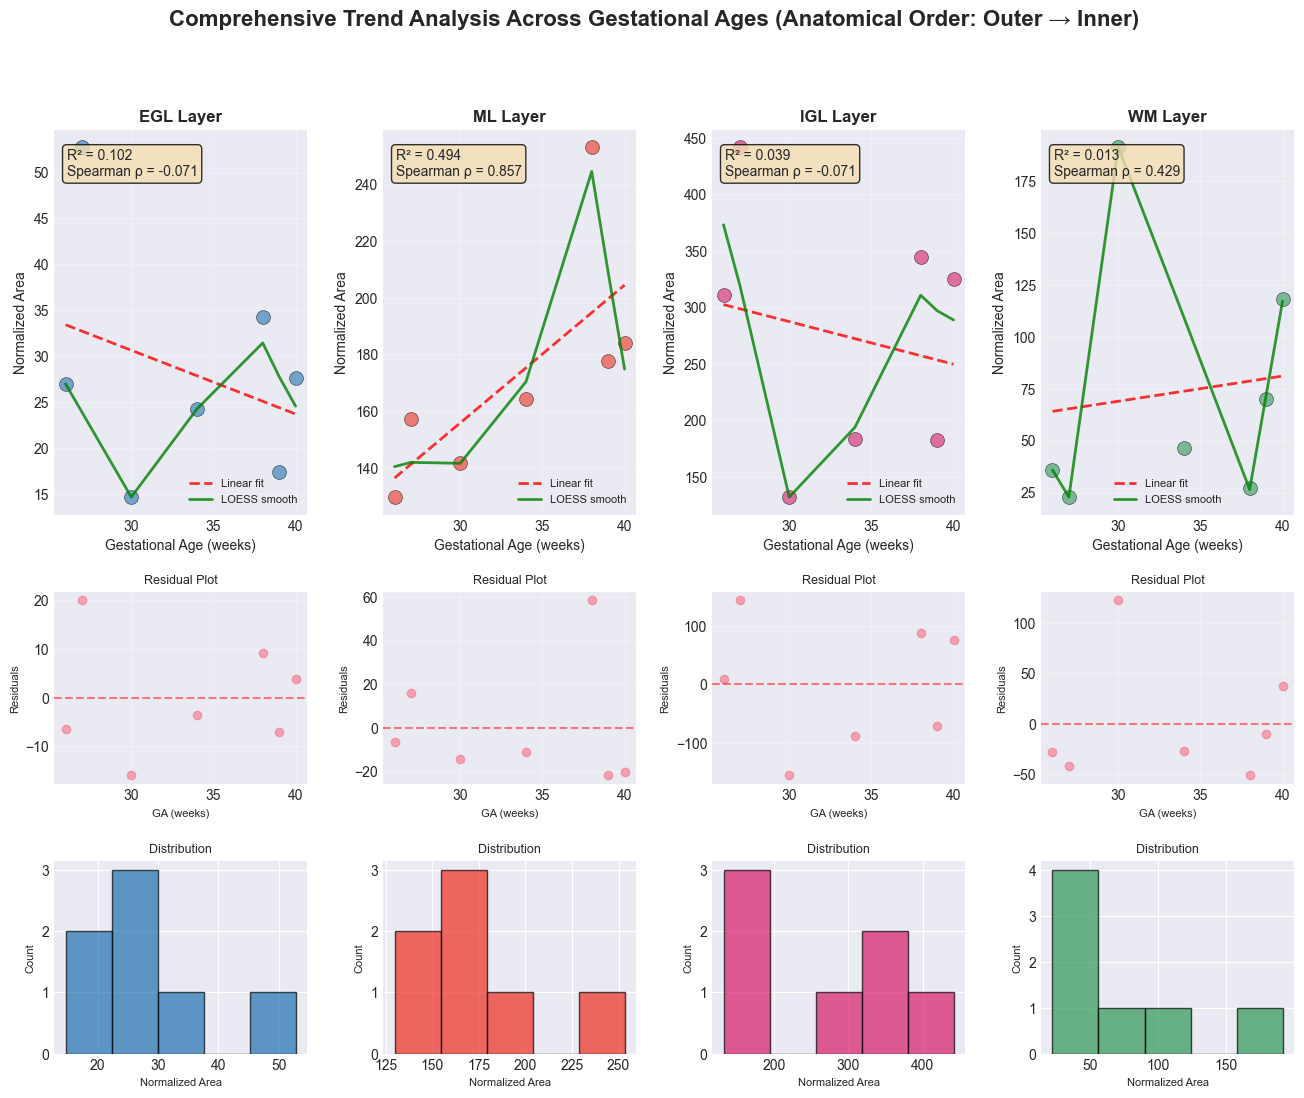


Mann-Kendall Trend Test (for monotonic trends):
EGL: S=-1.0, Z=0.000, p=1.000 - decreasing
ML: S=15.0, Z=2.103, p=0.035 - increasing
IGL: S=-1.0, Z=0.000, p=1.000 - decreasing
WM: S=7.0, Z=0.901, p=0.368 - increasing

Interpretation Guide:
- Shapiro-Wilk: p>0.05 suggests normal distribution
- Correlations: Use Spearman if data is not normally distributed
- Mann-Kendall: Tests for monotonic trends without assuming linearity
- LOESS: Shows potential non-linear patterns in the data
- Layer Order: EGL (outermost) → ML → IGL → WM (innermost)


In [10]:
# Analyze trends across gestational ages
print("Analyzing trends across gestational ages...\n")

# Import required libraries for statistical analysis
from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns

# Use anatomical order for all analyses
anatomical_order = ['EGL', 'ML', 'IGL', 'WM']  # Outer to Inner

# Check normality for each layer
print("Testing for normality (Shapiro-Wilk test):")
for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[col_name].dropna()
        if len(data) >= 3:  # Shapiro-Wilk requires at least 3 samples
            statistic, p_value = stats.shapiro(data)
            print(f"{layer}: W={statistic:.3f}, p={p_value:.3f} {'(Normal)' if p_value > 0.05 else '(Not Normal)'}")

# Calculate both Pearson and Spearman correlations
print("\n" + "="*60)
print("Correlation Analysis (Pearson vs Spearman):")
print("="*60)

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[['GA_weeks', col_name]].dropna()
        if len(data) >= 3:
            # Pearson correlation (assumes linear relationship and normal distribution)
            pearson_r, pearson_p = stats.pearsonr(data['GA_weeks'], data[col_name])
            
            # Spearman correlation (non-parametric, doesn't assume normality)
            spearman_r, spearman_p = stats.spearmanr(data['GA_weeks'], data[col_name])
            
            print(f"\n{layer} Layer:")
            print(f"  Pearson:  r={pearson_r:.3f}, p={pearson_p:.3f}")
            print(f"  Spearman: ρ={spearman_r:.3f}, p={spearman_p:.3f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Create a 3x4 grid: 4 scatter plots, 4 residual plots, 4 distribution plots
gs = fig.add_gridspec(3, 4, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

for i, layer in enumerate(anatomical_order):
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        plot_data = combined_df[['GA_weeks', col_name]].dropna()
        
        if len(plot_data) > 2:
            # Main scatter plot with both linear and LOESS smoothing
            ax_main = fig.add_subplot(gs[0, i])
            
            # Scatter plot
            ax_main.scatter(plot_data['GA_weeks'], plot_data[col_name],
                          s=100, alpha=0.6, color=plt.cm.get_cmap(color_schemes[layer])(0.7),
                          edgecolors='black', linewidth=0.5)
            
            # Linear trend line
            z = np.polyfit(plot_data['GA_weeks'], plot_data[col_name], 1)
            p = np.poly1d(z)
            ax_main.plot(plot_data['GA_weeks'], p(plot_data['GA_weeks']),
                        'r--', alpha=0.8, linewidth=2, label='Linear fit')
            
            # Add LOESS smoothing for non-linear trends
            if len(plot_data) >= 5:  # LOESS needs sufficient points
                smoothed = lowess(plot_data[col_name], plot_data['GA_weeks'], 
                                frac=0.6, it=3, return_sorted=True)
                ax_main.plot(smoothed[:, 0], smoothed[:, 1], 'g-', alpha=0.8, 
                           linewidth=2, label='LOESS smooth')
            
            # Calculate R² and add statistics
            r2 = r2_score(plot_data[col_name], p(plot_data['GA_weeks']))
            spearman_r, _ = stats.spearmanr(plot_data['GA_weeks'], plot_data[col_name])
            
            # Add text box with statistics
            textstr = f'R² = {r2:.3f}\nSpearman ρ = {spearman_r:.3f}'
            ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes,
                        verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            ax_main.set_xlabel('Gestational Age (weeks)', fontsize=10)
            ax_main.set_ylabel('Normalized Area', fontsize=10)
            ax_main.set_title(f'{layer} Layer', fontsize=12, fontweight='bold')
            ax_main.grid(True, alpha=0.3)
            ax_main.legend(fontsize=8)
            
            # Residual plot
            ax_resid = fig.add_subplot(gs[1, i])
            residuals = plot_data[col_name] - p(plot_data['GA_weeks'])
            ax_resid.scatter(plot_data['GA_weeks'], residuals, alpha=0.6)
            ax_resid.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax_resid.set_xlabel('GA (weeks)', fontsize=8)
            ax_resid.set_ylabel('Residuals', fontsize=8)
            ax_resid.set_title('Residual Plot', fontsize=9)
            ax_resid.grid(True, alpha=0.3)
            
            # Distribution plot
            ax_dist = fig.add_subplot(gs[2, i])
            ax_dist.hist(plot_data[col_name], bins=5, alpha=0.7, 
                        color=plt.cm.get_cmap(color_schemes[layer])(0.7),
                        edgecolor='black')
            ax_dist.set_xlabel('Normalized Area', fontsize=8)
            ax_dist.set_ylabel('Count', fontsize=8)
            ax_dist.set_title('Distribution', fontsize=9)

# Add main title
fig.suptitle('Comprehensive Trend Analysis Across Gestational Ages (Anatomical Order: Outer → Inner)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()

# Save figure
save_figure('comprehensive_trend_analysis', fig=fig)

plt.show()

# Non-parametric trend test (Mann-Kendall test for monotonic trends)
print("\n" + "="*60)
print("Mann-Kendall Trend Test (for monotonic trends):")
print("="*60)

def mann_kendall_test(x, y):
    """Simple Mann-Kendall test implementation"""
    n = len(x)
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign((x[j] - x[i]) * (y[j] - y[i]))
    
    # Calculate variance
    var_s = n * (n - 1) * (2 * n + 5) / 18
    
    # Calculate z-score
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return s, z, p_value

for layer in anatomical_order:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        data = combined_df[['GA_weeks', col_name]].dropna().sort_values('GA_weeks')
        if len(data) >= 3:
            s, z, p = mann_kendall_test(data['GA_weeks'].values, data[col_name].values)
            trend = "increasing" if s > 0 else "decreasing" if s < 0 else "no trend"
            print(f"{layer}: S={s}, Z={z:.3f}, p={p:.3f} - {trend}")

print("\n" + "="*60)
print("Interpretation Guide:")
print("- Shapiro-Wilk: p>0.05 suggests normal distribution")
print("- Correlations: Use Spearman if data is not normally distributed")
print("- Mann-Kendall: Tests for monotonic trends without assuming linearity")
print("- LOESS: Shows potential non-linear patterns in the data")
print("- Layer Order: EGL (outermost) → ML → IGL → WM (innermost)")
print("="*60)

## 8.5. Individual Sample Comparison - EGL, ML, IGL Layers

Consistent scale ranges for each layer across all samples:
EGL: 10.9 to 56.6
ML: 117.3 to 265.6
IGL: 101.1 to 472.8
Saved: sample_4276_publication_ready.pdf


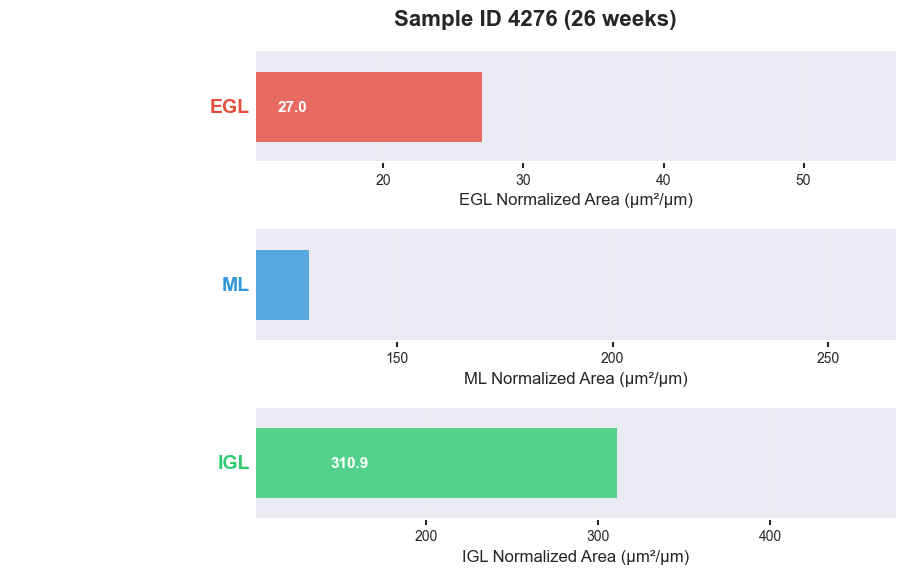

Saved: sample_934_publication_ready.pdf


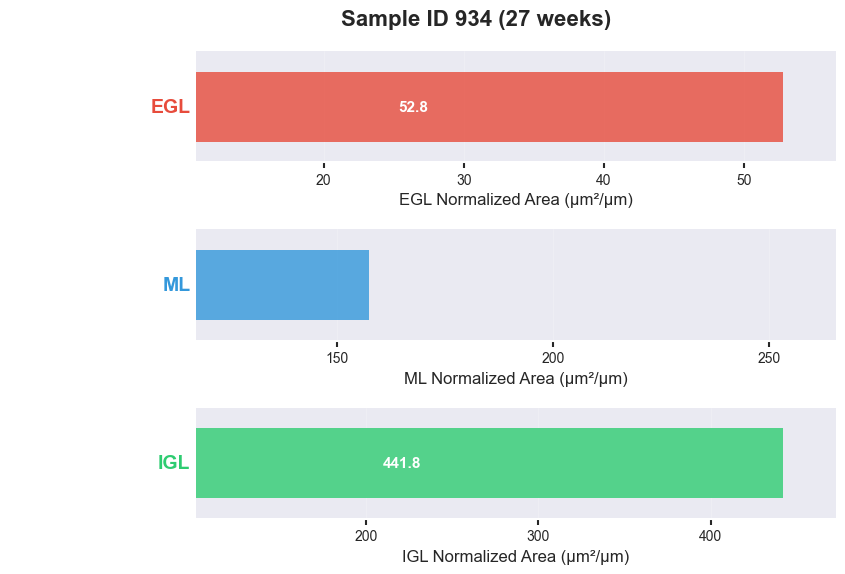

Saved: sample_4544_publication_ready.pdf


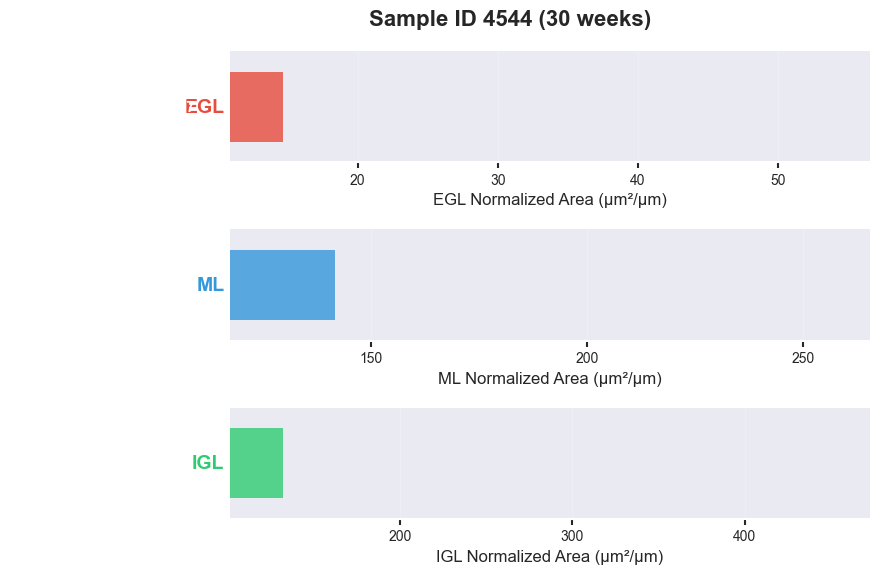

Saved: sample_4389_publication_ready.pdf


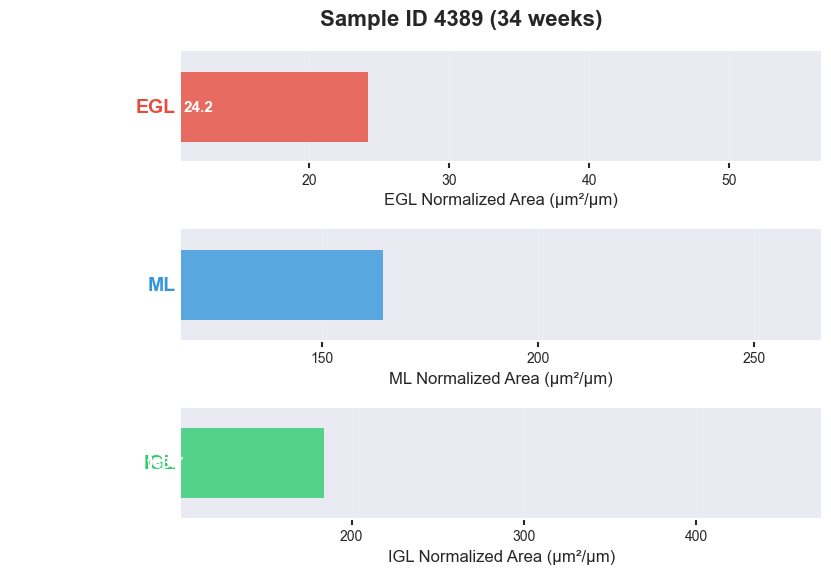

Saved: sample_1055_publication_ready.pdf


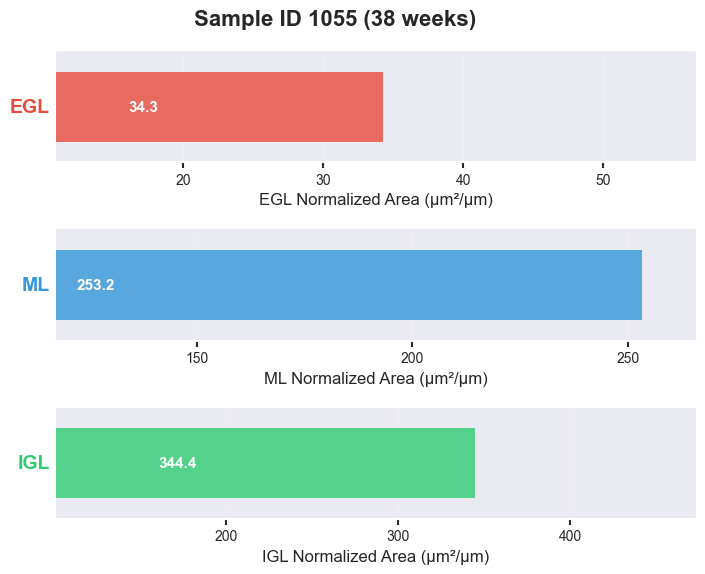

Saved: sample_1210_publication_ready.pdf


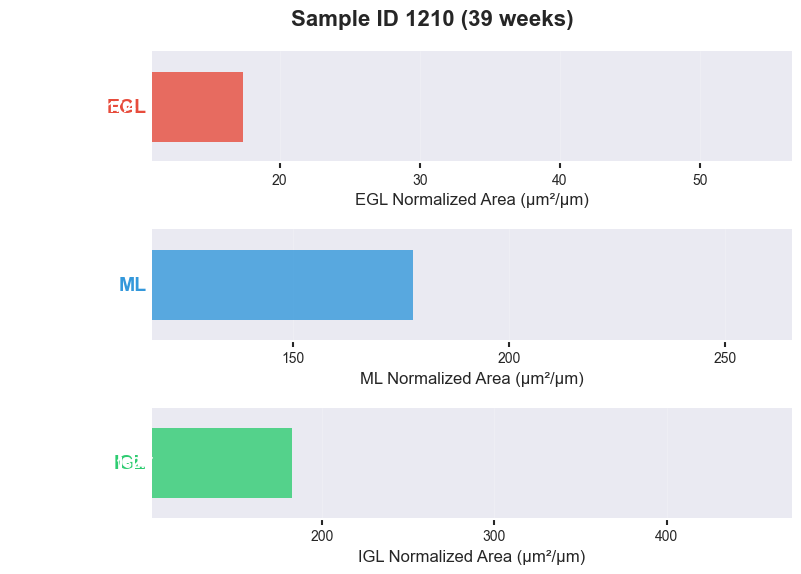

Saved: sample_1061_publication_ready.pdf


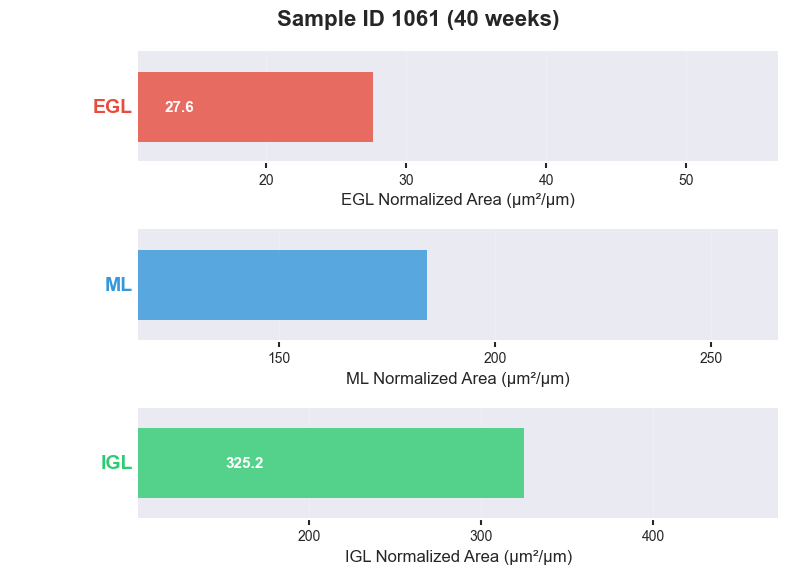


Summary Table - All Sample Values for Publication
Sample ID  GA (weeks)   EGL      ML       IGL     
--------------------------------------------------
4276       26           27.0     129.7    310.9   
934        27           52.8     157.4    441.8   
4544       30           14.7     141.6    132.0   
4389       34           24.2     164.1    183.7   
1055       38           34.3     253.2    344.4   
1210       39           17.4     177.8    182.7   
1061       40           27.6     184.1    325.2   

Scale ranges used:
EGL: 10.9 - 56.6 μm²/μm
ML: 117.3 - 265.6 μm²/μm
IGL: 101.1 - 472.8 μm²/μm

Note: All plots use consistent figure size (8x6 inches) and 300 DPI for publication quality.


In [ ]:
# %% [markdown]
# ## 8.5. Individual Sample Comparison - EGL, ML, IGL Layers (Publication Ready - Fixed Labels)

# %%
# Create individual sample comparison plots for EGL, ML, and IGL with separate scales (Publication Ready - Fixed Labels)
comparison_layers = ['EGL', 'ML', 'IGL']

# Get unique sample IDs sorted by GA
sample_data = combined_df[['ID', 'GA_weeks']].dropna().sort_values('GA_weeks')

# Define colors for each layer
layer_colors = {
    'EGL': '#e74c3c',  # Red
    'ML': '#3498db',   # Blue  
    'IGL': '#2ecc71'   # Green
}

# Calculate min and max for each layer across all samples for consistent scaling
layer_ranges = {}
for layer in comparison_layers:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        values = combined_df[col_name].dropna()
        if len(values) > 0:
            min_val = values.min()
            max_val = values.max()
            # Add 10% padding
            padding = (max_val - min_val) * 0.1
            layer_ranges[layer] = {
                'min': max(0, min_val - padding),  # Don't go below 0
                'max': max_val + padding
            }

print("Consistent scale ranges for each layer across all samples:")
for layer, range_info in layer_ranges.items():
    print(f"{layer}: {range_info['min']:.1f} to {range_info['max']:.1f}")

# Create separate plots for each sample with individual scales per layer - Publication Ready
for i, (_, row) in enumerate(sample_data.iterrows()):
    sample_id = row['ID']
    ga_weeks = row['GA_weeks']
    
    # Create figure with consistent size for publication
    fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # Consistent publication size
    
    for j, layer in enumerate(comparison_layers):
        ax = axes[j]
        col_name = f'{layer}_Normalized'
        
        if col_name in combined_df.columns:
            value = combined_df[combined_df['ID'] == sample_id][col_name].iloc[0] if len(combined_df[combined_df['ID'] == sample_id]) > 0 else np.nan
            
            if not np.isnan(value):
                # Create horizontal bar
                bar = ax.barh([0], [value], color=layer_colors[layer], alpha=0.8, height=0.5)
                
                # Smart label positioning to avoid labels going off the chart
                x_range = layer_ranges[layer]['max'] - layer_ranges[layer]['min']
                
                # If the bar takes up less than 30% of the range, put label outside
                if value < (layer_ranges[layer]['min'] + 0.3 * x_range):
                    # Position label to the right of the bar
                    label_x = value + 0.02 * x_range
                    label_color = layer_colors[layer]
                    ha = 'left'
                    # Make sure label doesn't go outside the plot area
                    if label_x > layer_ranges[layer]['max'] * 0.95:
                        label_x = layer_ranges[layer]['max'] * 0.95
                        ha = 'right'
                else:
                    # Position label in the center of the bar
                    label_x = value / 2
                    label_color = 'white'
                    ha = 'center'
                
                # Add value label with smart positioning
                ax.text(label_x, 0, f'{value:.1f}', ha=ha, va='center', 
                       fontweight='bold', fontsize=11, color=label_color)
                
                # Set the consistent scale for this layer
                ax.set_xlim(layer_ranges[layer]['min'], layer_ranges[layer]['max'])
                
            else:
                # Handle missing data
                ax.text(0.5, 0, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12, style='italic')
                ax.set_xlim(layer_ranges[layer]['min'], layer_ranges[layer]['max'])
        
        # Customize each subplot - Show x-axis for each layer
        ax.set_ylim(-0.4, 0.4)
        ax.set_yticks([])
        ax.set_ylabel(f'{layer}', fontsize=14, fontweight='bold', 
                     color=layer_colors[layer], rotation=0, ha='right', va='center')
        
        # Show x-axis labels for each subplot
        ax.set_xlabel(f'{layer} Normalized Area (μm²/μm)', fontsize=12)
        
        # Customize x-axis ticks for better readability
        if layer in layer_ranges:
            # Create nice tick marks
            min_val = layer_ranges[layer]['min']
            max_val = layer_ranges[layer]['max']
            
            # Generate 4-5 evenly spaced ticks
            tick_range = max_val - min_val
            if tick_range <= 50:
                tick_step = 10
            elif tick_range <= 100:
                tick_step = 20
            elif tick_range <= 200:
                tick_step = 50
            else:
                tick_step = 100
            
            # Calculate tick positions
            start_tick = int(min_val / tick_step) * tick_step
            if start_tick < min_val:
                start_tick += tick_step
            
            ticks = []
            current_tick = start_tick
            while current_tick <= max_val:
                ticks.append(current_tick)
                current_tick += tick_step
            
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{int(tick)}' for tick in ticks])
        
        # Add grid for easier reading
        ax.grid(True, axis='x', alpha=0.3, linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Remove unnecessary spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Make remaining spines thicker for publication
        ax.spines['bottom'].set_linewidth(1.5)
        
        # Adjust tick parameters for publication quality
        ax.tick_params(axis='x', labelsize=10, width=1.5, length=4)
    
    # Add main title with publication formatting
    fig.suptitle(f'Sample ID {sample_id} ({ga_weeks} weeks)', 
                fontsize=16, fontweight='bold', y=0.95)
    
    # Adjust spacing for publication
    plt.subplots_adjust(hspace=0.6, top=0.88, bottom=0.1, left=0.15, right=0.95)
    
    # Save individual figure with high DPI for publication
    save_figure(f'sample_{sample_id}_publication_ready_fixed', dpi=300)
    
    plt.show()

# Create a summary table of all values for easy reference
print("\n" + "="*80)
print("Summary Table - All Sample Values for Publication")
print("="*80)

# Create a formatted table
summary_table = []
for _, row in sample_data.iterrows():
    sample_id = row['ID']
    ga_weeks = row['GA_weeks']
    
    row_data = [f"{sample_id}", f"{ga_weeks}"]
    
    for layer in comparison_layers:
        col_name = f'{layer}_Normalized'
        if col_name in combined_df.columns:
            value = combined_df[combined_df['ID'] == sample_id][col_name].iloc[0] if len(combined_df[combined_df['ID'] == sample_id]) > 0 else np.nan
            if not np.isnan(value):
                row_data.append(f"{value:.1f}")
            else:
                row_data.append("N/A")
        else:
            row_data.append("N/A")
    
    summary_table.append(row_data)

# Print formatted table
headers = ["Sample ID", "GA (weeks)", "EGL", "ML", "IGL"]
print(f"{'Sample ID':<10} {'GA (weeks)':<12} {'EGL':<8} {'ML':<8} {'IGL':<8}")
print("-" * 50)
for row in summary_table:
    print(f"{row[0]:<10} {row[1]:<12} {row[2]:<8} {row[3]:<8} {row[4]:<8}")

print(f"\nScale ranges used:")
for layer in comparison_layers:
    if layer in layer_ranges:
        print(f"{layer}: {layer_ranges[layer]['min']:.1f} - {layer_ranges[layer]['max']:.1f} μm²/μm")

print(f"\nNote: All plots use consistent figure size (8x6 inches) and 300 DPI for publication quality.")
print("Labels are smartly positioned: inside bars when there's space, outside when bars are too small.")

## 9. Export Processed Data

In [11]:
# Save the processed data with normalized values
output_path = output_dir / 'normalized_cerebellar_measurements_by_GA.csv'
combined_df.to_csv(output_path, index=False)
print(f"\nProcessed data saved to: {output_path.name}")

# Create summary statistics table
summary_stats = pd.DataFrame()
for layer in layers:
    col_name = f'{layer}_Normalized'
    if col_name in combined_df.columns:
        stats = combined_df.groupby('GA_weeks')[col_name].agg(['mean', 'std', 'count'])
        stats.columns = [f'{layer}_{stat}' for stat in ['mean', 'std', 'count']]
        if summary_stats.empty:
            summary_stats = stats
        else:
            summary_stats = summary_stats.join(stats)

print("\nSummary statistics by gestational age:")
print(summary_stats.round(2))

# Save summary statistics
summary_output_path = output_dir / 'summary_stats_by_GA.csv'
summary_stats.to_csv(summary_output_path)
print(f"\nSummary statistics saved to: {summary_output_path.name}")

# Create a summary report
report_path = output_dir / 'analysis_summary.txt'
with open(report_path, 'w') as f:
    f.write("Neuropathology Visium Analysis Summary\n")
    f.write("="*50 + "\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Number of subjects: {len(combined_df)}\n")
    f.write(f"GA range: {combined_df['GA_weeks'].min()}-{combined_df['GA_weeks'].max()} weeks\n\n")
    
    f.write("Normalization method: Layer Area / (ML_IGL_150µm Perimeter ÷ 2)\n\n")
    
    f.write("Layer Statistics (averaged by subject):\n")
    for layer in anatomical_order:
        if f'{layer}_Normalized' in combined_df.columns:
            data = combined_df[f'{layer}_Normalized'].dropna()
            f.write(f"\n{layer} Layer:\n")
            f.write(f"  Mean: {data.mean():.2f} µm²/µm\n")
            f.write(f"  Std: {data.std():.2f}\n")
            f.write(f"  Range: {data.min():.2f} - {data.max():.2f}\n")

print(f"\nAnalysis summary saved to: {report_path.name}")

# List all saved files
print("\n" + "="*50)
print("All files saved to output directory:")
print("="*50)
for file in sorted(output_dir.glob('*')):
    print(f"  - {file.name}")


Processed data saved to: normalized_cerebellar_measurements_by_GA.csv

Summary statistics by gestational age:
          ML_mean  ML_std  ML_count  IGL_mean  IGL_std  IGL_count  EGL_mean  \
GA_weeks                                                                      
26         129.67     NaN         1    310.92      NaN          1     27.01   
27         157.36     NaN         1    441.78      NaN          1     52.77   
30         141.59     NaN         1    132.05      NaN          1     14.68   
34         164.11     NaN         1    183.72      NaN          1     24.23   
38         253.22     NaN         1    344.41      NaN          1     34.28   
39         177.76     NaN         1    182.70      NaN          1     17.37   
40         184.07     NaN         1    325.23      NaN          1     27.62   

          EGL_std  EGL_count  WM_mean  WM_std  WM_count  
GA_weeks                                                 
26            NaN          1    35.83     NaN         1  
27 

## 10. Key Findings Summary
 
This analysis provides:
1. **Normalized area measurements** for each cerebellar layer (ML, IGL, EGL, WM)
2. **Heatmaps sorted by gestational age** showing development patterns
3. **Correlation analysis** between gestational age and layer development
4. **Trend visualization** to identify developmental patterns

### Notes:
- Normalization formula: Total Area / (Layer Perimeter ÷ 2)
- Data excludes sample 1208 as specified
- Special attention should be paid to samples 1208B and 4389B due to different resolution (0.62 µm vs 0.31 µm)

In [12]:
print("\nAnalysis complete! 🎉")
print("\nRemember to check samples with different resolutions (4389B) for any anomalies in the measurements.")


Analysis complete! 🎉

Remember to check samples with different resolutions (4389B) for any anomalies in the measurements.
